In [3]:
import pandas as pd
import os
import FinanceDataReader as fdr
import numpy as np
import math
import sklearn
import sklearn.preprocessing
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm


In [4]:
path = './'
list_name = 'stock_list.csv'
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list = stock_list.sort_values("종목코드")
stock_list

,종목명,종목코드,상장시장
109,메리츠화재,000060,KOSPI
126,하이트진로,000080,KOSPI
67,유한양행,000100,KOSPI
69,CJ대한통운,000120,KOSPI
156,두산,000150,KOSPI
...,...,...,...
328,넥스틴,348210,KOSDAQ
31,하이브,352820,KOSPI
199,솔브레인,357780,KOSDAQ
176,티와이홀딩스,363280,KOSPI


In [5]:
data = pd.DataFrame()
volume = pd.DataFrame()
high = pd.DataFrame()
low = pd.DataFrame()

start_date = '20160104'
end_date = '20200214'


for stock_code in stock_list["종목코드"]:
    stock = fdr.DataReader(stock_code, start = start_date, end = end_date)
    data = pd.concat([data,stock["Close"]], axis=1)
    volume = pd.concat([volume, stock["Volume"]], axis=1)
    high = pd.concat([high,stock["High"]], axis=1)
    low = pd.concat([low,stock["Low"]], axis=1)

data.columns = stock_list["종목코드"]
volume.columns = stock_list["종목코드"]
high.columns = stock_list["종목코드"]
low.columns = stock_list["종목코드"]

In [6]:
import urllib
from urllib import request
import re
import json
from datetime import datetime
 
client_id = '3MEWopdxXDExnqYxHvfd'
client_secret = '02BZ16k7Zc'
 
url = "https://openapi.naver.com/v1/datalab/search"
trend = pd.DataFrame()
for stock in stock_list.iterrows():
    body = {"startDate":"2016-01-01",
            "endDate":"2021-11-27",
            "timeUnit":"date",
            "keywordGroups":[{"groupName":stock[1]["종목코드"],
                              "keywords":[stock[1]["종목코드"],stock[1]["종목명"]]}]}
    body = json.dumps(body, )

    request = urllib.request.Request(url)# 이건 HTTP Header 변경시에 사용하는 라인, 필요없으면 바로 urllib.request.urlopen()으로 ㄱㄱ
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    request.add_header("Content-Type","application/json")

    response = urllib.request.urlopen(request, data=body.encode("utf-8")) # 메서드로 크롤링할 웹페이지 가져옴
    rescode = response.getcode() #HTTP 응담 상태 코드
    if(rescode==200):
        response_body = response.read()
        scraped = response_body.decode('utf-8')
    else:
        print("Error Code:" + rescode)

    result = json.loads(scraped)

    trend_data = result['results'][0]['data']
    time = [pd.to_datetime(i['period']) for i in trend_data]

    value = [i['ratio'] for i in trend_data]
    trend_data = pd.DataFrame({stock[1]["종목코드"]: value}, index=time)
    trend = pd.concat([trend, trend_data], axis=1)
trend = trend.fillna(0)
trend = trend.loc[pd.DatetimeIndex(data.index), :]

In [7]:
trend

,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
2016-01-04,65.92254,2.29327,0.10448,4.31464,3.20316,0.05887,0.54534,3.70184,1.54837,5.22629,...,0.00000,0.01247,0.00000,0.00000,0.00000,0.03475,15.70640,0.62210,0.00000,0.28484
2016-01-05,57.28149,2.58999,0.10517,6.99689,2.53102,0.05887,0.60650,3.58598,1.57327,4.52595,...,0.00000,0.01128,0.00000,0.00000,0.00000,0.02780,36.58547,0.55077,0.00000,0.30991
2016-01-06,61.53591,2.35856,0.11476,6.72325,2.87593,0.07654,0.61921,4.09091,1.44472,4.25457,...,0.00000,0.01162,0.00000,0.00000,0.00000,0.02432,8.97264,0.50301,0.00000,0.39888
2016-01-07,54.88087,6.99299,0.13935,5.81084,2.49370,0.05299,0.58704,3.83773,1.41008,4.07073,...,0.00000,0.00717,0.00000,0.00000,0.00000,0.02780,5.79045,0.55812,0.00000,0.31624
2016-01-08,49.66198,6.35818,0.14592,5.55813,2.22932,0.07654,0.49529,3.59170,1.58116,4.21080,...,0.00000,0.00854,0.00000,0.00000,0.00000,0.00000,5.34289,0.45372,0.00000,0.28732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-10,52.05059,4.61846,0.15589,5.32961,1.13568,0.00000,1.33892,7.00175,3.93747,5.49768,...,0.01513,1.05902,0.11156,0.01448,0.03749,0.27801,0.42400,2.23799,0.04466,0.45205
2020-02-11,48.81771,5.14662,0.15278,6.97392,1.22288,0.00000,2.01216,7.48237,4.29559,8.45662,...,0.01788,1.12484,0.00942,0.01945,0.02763,0.23631,0.55249,2.38770,0.03509,0.40825
2020-02-12,48.89883,6.48369,0.14248,6.48202,1.20285,0.03532,1.57803,6.99317,4.07304,10.31252,...,0.03715,0.84551,0.00000,0.01448,0.03026,0.30234,0.55891,2.71406,0.00000,0.43993
2020-02-13,44.92683,5.13428,0.13955,6.35771,1.32424,0.00000,1.55777,6.61126,4.68947,8.38658,...,0.03394,0.77815,0.00785,0.01862,0.03749,0.36837,0.50109,2.36933,0.01914,0.39696


In [8]:
result = []
for i in range(370):
    corr = pd.concat([trend.iloc[:, i], data.iloc[:, i]], axis=1).corr().iloc[1,0]
    result.append(corr)
result = pd.DataFrame(result).fillna(0)

In [21]:
stock_list.loc[result[(abs(result[0]) > 0.7)].index,:]

,종목명,종목코드,상장시장
22,HMM,011200,KOSPI
88,녹십자,006280,KOSPI
94,한국항공우주,047810,KOSPI
115,DB하이텍,000990,KOSPI
121,더존비즈온,012510,KOSPI
140,농심,004370,KOSPI
181,한국콜마,161890,KOSPI
187,에코프로비엠,247540,KOSDAQ
205,LX세미콘,108320,KOSDAQ
226,레고켐바이오,141080,KOSDAQ


In [31]:
result[(abs(result[0]) > 0.7)]

,0
22,-0.702320
88,0.879583
94,0.820751
115,0.783749
121,0.754590
140,0.732521
181,0.756753
187,0.708303
205,0.827511
226,0.746141


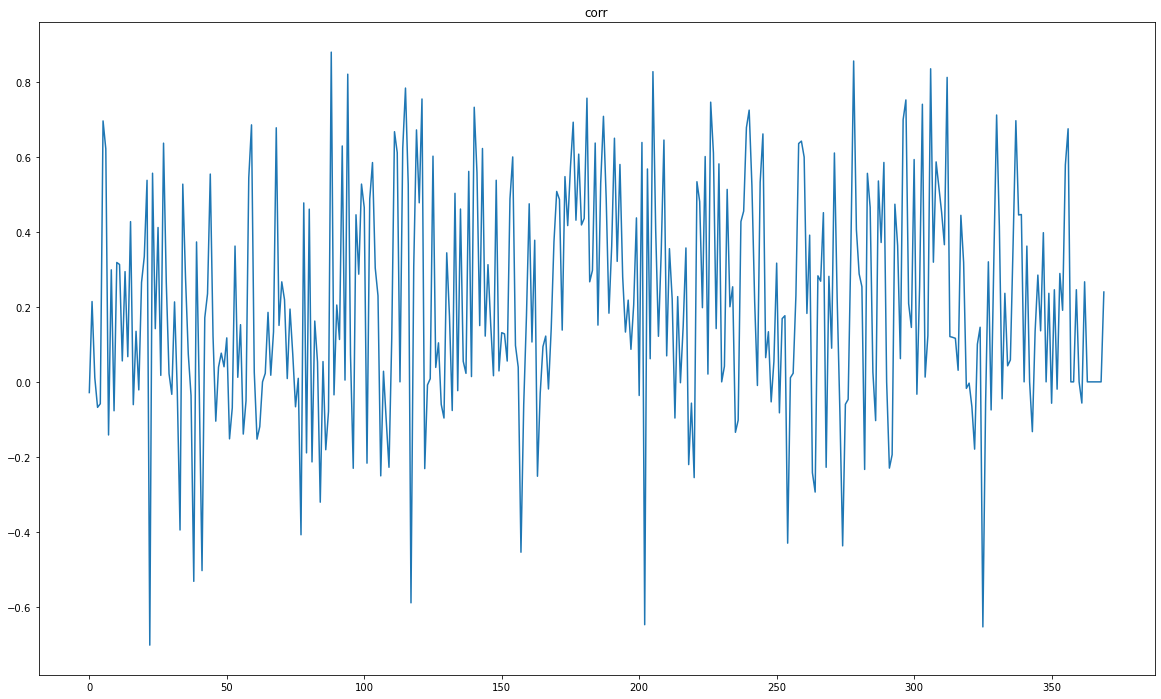

In [24]:
plt.figure(figsize=(20,12))
plt.title("corr")
plt.plot(result)